# **Multivariate Climate Data Clustering using Deep Spatiotemporal Clustering (DSC) Model**
Here we are dealing with climate data that comprises spatial information, time information, and scientific values. The dataset contains the value of 7 parameters for a region of 41 longitudes and 41 latitudes for 365 days in a year.

Our goal is to create meaningful clusters based on the values of these 7 parameters. As the data dimension is high we planned to use deep learning-based models to generate the latent representation of each day and then generate clusters for 365 days.

As our dataset has spatial and temporal features, therefore we have developed a new CNN-LSTM Autoencoder model that learns the spatial features first from the dataset. The output of the CNN model is then passed through the LSTM model to learn the temporal features and generate the final latent variables. Using the final latent variables we perform the clustering to 365 days into different groups. In the decoder module, we reconstruct the input data from the latent features of the LSTM layer. The model is optimized jointly using the reconstruction loss and clustering loss.

The data dimension of each day is 41x41x7. As the dimension is not divisible by 2, we added 7 rows and 7 columns of zeros to our actual dataset to make the dataset of size 48x48x7. This makes the decoder part well-balanced with the encoder counterpart.

# **1. Model Creation:**
This Autoencoder model considers each observation data as an image of size 48x48x7. The model takes a 365x1x48x48x7 NumPy array as input and applies convolution layers, and max pooling layers to learn the spatial features. Then applies the LSTM layers with dropout and dense layers to learn the temporal features. The output of this model is 256 latent features for each data point. The decoder part takes the 256 latent features of the encoder as input and applies stacks of upsampling and convolution layers to reconstruct the input data.



In [ ]:
import keras,os
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D , Flatten, Dropout, AveragePooling2D, LSTM, Activation, ConvLSTM2D, TimeDistributed, Input, Reshape
from keras.layers import UpSampling1D, Conv2DTranspose, UpSampling2D
import numpy as np

def get_model(input_dims):
  input_batch = Input(shape = input_dims)

  conv_model = TimeDistributed(Conv2D(64, (3,3), padding='same', activation='tanh'), name='ConvL1')(input_batch)
  conv_model = TimeDistributed(Conv2D(64, (3,3), padding='same', activation='tanh'), name='ConvL2' )(conv_model)
  conv_model = TimeDistributed(MaxPool2D(pool_size=(2,2), padding='same',strides=(2,2)))(conv_model)
  conv_model = TimeDistributed(Conv2D(128, (3,3), padding='same', activation='tanh'), name='ConvL3' )(conv_model)
  conv_model = TimeDistributed(MaxPool2D(pool_size=(2,2), padding='same',strides=(2,2)))(conv_model)
  conv_model = TimeDistributed(Conv2D(256, (3,3), padding='same', activation='tanh'), name='ConvL4' )(conv_model)
  conv_model = TimeDistributed(MaxPool2D(pool_size=(2,2), padding='same',strides=(2,2)))(conv_model)
  conv_model = TimeDistributed(Conv2D(512, (3,3), padding='same', activation='tanh'), name='ConvL5' )(conv_model)
  conv_model = TimeDistributed(MaxPool2D(pool_size=(2,2), padding='same',strides=(2,2)))(conv_model)
  conv_model = TimeDistributed(Flatten())(conv_model)

  lstm_network = LSTM(512, return_sequences=True,dropout=0.1,recurrent_dropout=0.1)(conv_model)
  lstm_network = keras.layers.LSTM(512, return_sequences=False,dropout=0.1,recurrent_dropout=0.1)(lstm_network)
  lstm_network = keras.layers.Dense(256,activation='sigmoid', name='Dense1')(lstm_network)

  decoder_network = Dense(4608, name='dense1')(lstm_network)
  decoder_network = Reshape((3, 3, 512), name='reshape_1') (decoder_network)
  decoder_network = UpSampling2D((2, 2))(decoder_network)
  decoder_network = Conv2D(512, (3, 3), activation="tanh", padding="same")(decoder_network)
  decoder_network = UpSampling2D((2, 2))(decoder_network)
  decoder_network = Conv2D(256, (3, 3), activation="tanh", padding="same")(decoder_network)
  decoder_network = UpSampling2D((2, 2))(decoder_network)
  decoder_network = Conv2D(128, (3, 3), activation="tanh", padding="same")(decoder_network)
  decoder_network = UpSampling2D((2, 2))(decoder_network)
  decoder_network = Conv2D(64, (3, 3), activation="tanh", padding="same")(decoder_network)
  decoder_network = Conv2D(input_dims[3], (3, 3), activation="tanh", padding="same")(decoder_network)

  autoencoder = Model(inputs=input_batch, outputs=decoder_network, name='AE')

  encoder = Model(inputs=input_batch, outputs=lstm_network, name='encoder')

  return autoencoder, encoder


In [ ]:
from time import time
import numpy as np
import keras.backend as K
from tensorflow.keras.layers import Layer, InputSpec
from keras.layers import Dense, Input, Dropout
from keras.models import Model
from keras.optimizers import SGD
from keras import callbacks
from keras.initializers import VarianceScaling
from sklearn.cluster import KMeans


class ClusteringLayer(Layer):

    def __init__(self, n_clusters, weights=None, alpha=1.0, **kwargs):
        if 'input_shape' not in kwargs and 'input_dim' in kwargs:
            kwargs['input_shape'] = (kwargs.pop('input_dim'),)
        super(ClusteringLayer, self).__init__(**kwargs)
        self.n_clusters = n_clusters
        self.alpha = alpha
        self.initial_weights = weights
        self.input_spec = InputSpec(ndim=2)

    def build(self, input_shape):
        print(input_shape)
        assert len(input_shape) == 2
        input_dim = input_shape[1]
        self.input_spec = InputSpec(dtype=K.floatx(), shape=(None, input_dim))
        self.clusters = self.add_weight(shape=(self.n_clusters, input_dim), initializer='normal', name='clusters') #glorot_uniform
        if self.initial_weights is not None:
            self.set_weights(self.initial_weights)
            del self.initial_weights
        self.built = True

    def call(self, inputs, **kwargs):
        """ student t-distribution, as same as used in t-SNE algorithm.
                 q_ij = 1/(1+dist(x_i, u_j)^2), then normalize it.
        Arguments:
            inputs: the variable containing data, shape=(n_samples, n_features)
        Return:
            q: student's t-distribution, or soft labels for each sample. shape=(n_samples, n_clusters)
        """
        q = 1.0 / (1.0 + (K.sum(K.square(K.expand_dims(inputs, axis=1) - self.clusters), axis=2) / self.alpha))
        q **= (self.alpha + 1.0) / 2.0
        q = K.transpose(K.transpose(q) / K.sum(q, axis=1))
        return q


    def compute_output_shape(self, input_shape):
        assert input_shape and len(input_shape) == 2
        return input_shape[0], self.n_clusters

    def get_config(self):
        config = {'n_clusters': self.n_clusters}
        base_config = super(ClusteringLayer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))


class CNNModel(object):
    def __init__(self,
                 dims,
                 n_clusters=10,
                 alpha=1.0,
                 init='glorot_uniform'):

        super(CNNModel, self).__init__()

        self.dims = dims
        self.n_stacks = len(self.dims) - 1

        self.n_clusters = n_clusters
        self.alpha = alpha
        self.model_AE, self.model_cnn = get_model(self.dims);
        print("====Model created=====")

        # prepare the CNN model with cnn_layers+clustering _layer
        clustering_layer = ClusteringLayer(self.n_clusters, name='clustering')(self.model_cnn.output)
        print("====== clustering layer created ========")
        self.model = Model(inputs=self.model_AE.input, outputs=[self.model_AE.output, clustering_layer])


    def load_weights(self, weights):  # load weights
        self.model.load_weights(weights)

    def extract_features(self, x):
        return self.model_cnn.predict(x)

    def predict(self, x):  # predict cluster labels using the output of clustering layer
        q = self.model.predict(x, verbose=0)[1]
        return q.argmax(1)

    @staticmethod
    def target_distribution(q):
        weight = q ** 2 / q.sum(0)
        return (weight.T / weight.sum(1)).T

    def compile(self, optimizer='sgd', loss='kld'):
        self.model.compile(optimizer=optimizer, loss=['mse', 'kld'])

    def fit(self, x, y=None, maxiter=2e4, batch_size=256, tol=1e-3,
            update_interval=140, save_dir='./results/temp'):

        print('Update interval', update_interval)
        save_interval = 500
        print('Save interval', save_interval)

        # Step 1: initialize cluster centers using k-means
        t1 = time()
        print('Initializing cluster centers with k-means.')
        kmeans = KMeans(n_clusters=self.n_clusters, init = 'random', n_init=30)
        y_pred = kmeans.fit_predict(self.model_cnn.predict(x))
        y_pred_last = np.copy(y_pred)
        self.model.get_layer(name='clustering').set_weights([kmeans.cluster_centers_])

        # Step 2: deep clustering
        # logging file
        import csv
        logfile = open(save_dir + '/cnn_log.csv', 'w')
        logwriter = csv.DictWriter(logfile, fieldnames=['iter','loss'])
        logwriter.writeheader()

        loss = 0
        index = 0
        index_array = np.arange(x.shape[0])
        patience_cnt = 0
        patience = 10
        for ite in range(int(maxiter)):
            if ite % update_interval == 0:
                q = self.model.predict(x, verbose=0)[1]
                p = self.target_distribution(q)  # update the auxiliary target distribution p

                # evaluate the clustering performance
                y_pred = q.argmax(1)
                print("#### inside iteration ### ", ite)

                # check stop criterion
                delta_label = np.sum(y_pred != y_pred_last).astype(np.float32) / y_pred.shape[0]
                print("##### Prediction in side the iter and the delta_label is ", delta_label)
                y_pred_last = np.copy(y_pred)
                if ite > 0 and delta_label < tol:
                    patience_cnt += 1
                    print('Assignment changes {} < {} tolerance threshold. Patience: {}/{}.'.format(delta_label, tol, patience_cnt, patience))
                    print('Reached tolerance threshold. Stopping training.')
                    logfile.close()
                    break

            idx = index_array[index * batch_size: min((index+1) * batch_size, x.shape[0])]
            loss = self.model.train_on_batch(x=x[idx], y=[x[idx],p[idx]])
            print("#### the loss is ", loss)
            index = index + 1 if (index + 1) * batch_size <= x.shape[0] else 0

            # save intermediate model
            if ite % save_interval == 0:
                print('saving model to:', save_dir + '/CNN_model_' + str(ite) + '.h5')
                self.model.save_weights(save_dir + '/CNN_model_' + str(ite) + '.h5')

            ite += 1

        # save the trained model
        logfile.close()
        file_name  = "/CNN_model_final_" + str(round(time()))+ ".h5"
        print('saving model to:', save_dir + file_name)
        self.model.save_weights(save_dir + file_name)

        return y_pred

In [ ]:
! pip install netCDF4

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 16.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 10.9 MB/s eta 0:00:00


In [ ]:
import netCDF4 as nc
import pandas as pd
import numpy as np
import xarray as xr
import datetime
import datetime as dt
from netCDF4 import date2num,num2date
from math import sqrt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **2. Data preparation**
The dataset has some NaN values in the SST variable. To replace these NaN values we have used the mean value of the full dataset. The function returns 2 NumPy arrays one with size (365, 11767) and another with size (365, 1, 48, 48, 7). The array with size (365, 11767) is used to calculate the silhouette score and the array with size (365, 1, 48, 48, 7) is used to train the model.

In [ ]:
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler

def data_preprocessing(data_path):
  rdata_daily = xr.open_dataset(data_path)    # data_path = '/content/drive/MyDrive/ERA5_Dataset.nc'
  rdata_daily_np_array = np.array(rdata_daily.to_array())   # the shape of the dailt data is (7, 365, 41, 41)
  rdata_daily_np_array_latitude = np.concatenate((rdata_daily_np_array, np.zeros((7, 365, 41,7), dtype=int)), axis=3)
  rdata_daily_np_array_longitude = np.concatenate((rdata_daily_np_array_latitude, np.zeros((7, 365, 7, 48), dtype=int)), axis=2)
  rdata_daily_np_array = rdata_daily_np_array_longitude
  rdata_daily_np_array_T = rdata_daily_np_array.transpose(1,0,2,3)   # transform the dailt data from (7, 365, 41, 41) to (365, 7, 41, 41)
  overall_mean = np.nanmean(rdata_daily_np_array_T[:, :, :, :])
  for i in range(rdata_daily_np_array_T.shape[0]):
    for j in range(rdata_daily_np_array_T.shape[1]):
      for k in range(rdata_daily_np_array_T.shape[2]):
        for l in range(rdata_daily_np_array_T.shape[3]):
          if np.isnan(rdata_daily_np_array_T[i, j, k, l]):
            #print("NAN data in ", i, j, k, l)
            rdata_daily_np_array_T[i, j, k, l] = overall_mean
  rdata_daily_np_array_T = rdata_daily_np_array_T.transpose(0,2,3,1)
  rdata_daily_np_array_T_R = rdata_daily_np_array_T.reshape((rdata_daily_np_array_T.shape[0], -1))  # transform the dailt data from (365, 7, 41, 41) to (365, 11767)
  min_max_scaler = preprocessing.MinMaxScaler() # calling the function
  rdata_daily_np_array_T_R_nor = min_max_scaler.fit_transform(rdata_daily_np_array_T_R)   # now normalize the data, otherwise the loss will be very big
  #rdata_daily_np_array_T_R_nor = np.float32(rdata_daily_np_array_T_R_nor)    # convert the data type to float32, otherwise the loass will be out-of-limit
  rdata_daily_np_array_T_R_nor_R = rdata_daily_np_array_T_R_nor.reshape((rdata_daily_np_array_T_R_nor.shape[0], 1, rdata_daily_np_array.shape[2], rdata_daily_np_array.shape[3], rdata_daily_np_array.shape[0]))
  return rdata_daily_np_array_T_R_nor, rdata_daily_np_array_T_R_nor_R


In [ ]:
data_nor_eval, data_clustering = data_preprocessing('/content/data/ERA5_Dataset.nc')

In [ ]:
data_nor_eval.shape, data_clustering.shape

((365, 16128), (365, 1, 48, 48, 7))

# **3. Model Training**
This function defines related parameters to train the model. Then instantiate the model and train on the pre-processed data. The model tries to optimize the clustering loss and the reconstruction loss. After training the model returns the cluster assignment for each data point of the input dataset.

In [ ]:
def main():
    # setting the hyper parameters

    batch_size = 8 # Number of input will be considerer for each training iteration
    maxiter = 2e4 # Maximum number of times the model traning will iterate
    update_interval = 50 # After each interval the clustering weights will be modified
    tol = 0.0000001 # If there is a cluster change more than this tollerance the model training will run
    save_dir = '/content/drive/MyDrive/My_DSE-result' # The trained model will be stored here

    # load dataset
    x = data_clustering  # Input dataset of the transformed daily data
    y = None             # The cluster level of input data. Not available for our dataset.
    n_clusters = 7       # Number of clusters we want to generate.


    # prepare the model
    init = VarianceScaling(scale=1. / 3., mode='fan_in', distribution='uniform')
    cnnmodel = CNNModel(dims=x.shape[1:5], n_clusters=n_clusters, init=init)

    cnnmodel.model.summary()
    t0 = time()
    cnnmodel.compile(optimizer=SGD(0.0000001, 0.9), loss='kld')
    y_pred = cnnmodel.fit(x, y=y, tol=tol, maxiter=maxiter, batch_size=batch_size,
                     update_interval=update_interval, save_dir=save_dir)
    #print('acc:', metrics.acc(y, y_pred))
    print('clustering time: ', (time() - t0))
    return y_pred

In [ ]:
from sklearn.metrics import silhouette_samples, silhouette_score
def silhouette_score(X, labels, *, metric="cosine", sample_size=None, random_state=None, **kwds):
 return np.mean(silhouette_samples(X, labels, metric="cosine", **kwds))

In [ ]:
result = main()
silhouette_avg_rdata_daily = silhouette_score(data_nor_eval, result)
print("The average silhouette_score is :", silhouette_avg_rdata_daily)

In [ ]:
silhouette_avg_rdata_daily = silhouette_score(data_nor_eval, result)
print("The average silhouette_score is :", silhouette_avg_rdata_daily)

The average silhouette_score is : 0.373127491991956


In [ ]:
from sklearn.metrics import davies_bouldin_score
print("Davies-Bouldin score is ", davies_bouldin_score(data_nor_eval, result))

Davies-Bouldin score is  1.4348555090573796


# **4. Model testing with pre-trained weights:**
To test the model on other datasets we have to create the model and initialize the model with pre-trained weights stored in the drive. Then we have to call the main function to get the clustering results.

In [ ]:
def main_test():
    # setting the hyper parameters

    batch_size = 8 # Number of input will be considerer for each training iteration
    maxiter = 2e4 # Maximum number of times the model traning will iterate
    update_interval = 50 # After each interval the clustering weights will be modified
    tol = 0.0000001 # If there is a cluster change more than this tollerance the model training will run
    save_dir = '/content/drive/MyDrive/My_DSE-result' # The trained model will be stored here

    # load dataset
    x = data_clustering  # Input dataset of the transformed daily data
    y = None             # The cluster level of input data. Not available for our dataset.
    n_clusters = 7       # Number of clusters we want to generate.

    # prepare the model
    init = VarianceScaling(scale=1. / 3., mode='fan_in', distribution='uniform')
    cnnmodel = CNNModel(dims=x.shape[1:5], n_clusters=n_clusters, init=init)

    cnnmodel.model.summary()
    cnnmodel.load_weights('/content/drive/MyDrive/My_DSE-result/model_final.h5')
    t0 = time()
    y_pred = cnnmodel.predict(x)
    print('clustering time: ', (time() - t0))
    return y_pred

In [ ]:
result = main_test()
result

In [ ]:
silhouette_avg_rdata_daily = silhouette_score(data_nor_eval, result)
print("The average silhouette_score is :", silhouette_avg_rdata_daily)

## **5. Plotting the clustering results:**
To plot the clustering results first we have to create the model and initialize the model with pre-trained weights. Then we will create a new model by taking the Dense layer output and clustering output from the original model. The Dense layer output will be used to plot the clusters using the dimension reduction algorithm.

In [ ]:
n_clusters = 7
init = VarianceScaling(scale=1. / 3., mode='fan_in', distribution='uniform')
cnnmodel = CNNModel(dims=data_clustering.shape[1:5], n_clusters=n_clusters, init=init)

cnnmodel.model.summary()
cnnmodel.load_weights('/content/drive/MyDrive/My_DSE-result/model_final.h5')

In [ ]:
gradModel = Model(
			inputs=[cnnmodel.model.input],
			outputs=[cnnmodel.model.get_layer('Dense1').output,
				cnnmodel.model.output])

In [ ]:
(convOutputs, predictions) = gradModel(data_clustering)

Text(0, 0.5, 'Feature-2')

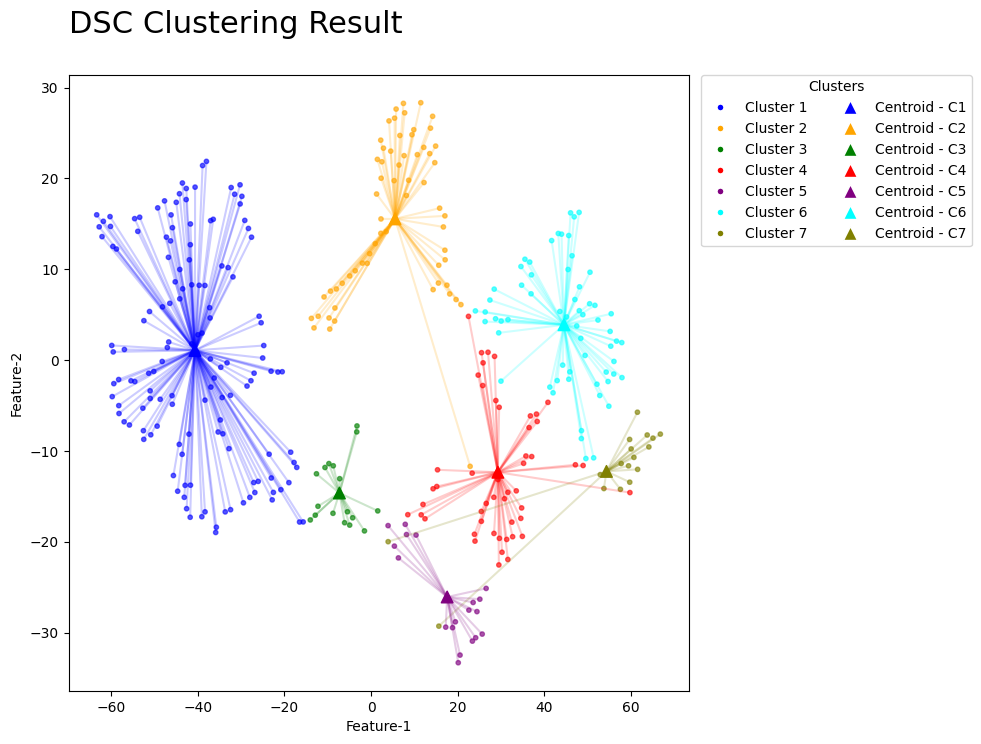

In [ ]:
from matplotlib.lines import Line2D
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

tsne = TSNE(n_components=2, learning_rate='auto', perplexity=10)
tsne_data = tsne.fit_transform(convOutputs)

tsne_df = pd.DataFrame(tsne_data, columns=['TSNE1','TSNE2'])
tsne_df['cluster'] = pd.Categorical(result)

Clusters = {}
Cluster_Centers = {}
for i in set(result):
    Clusters['Cluster' + str(i)] = np.array(tsne_df[tsne_df.cluster == i].drop(columns=['cluster']))
for i in range(len(Clusters)):
    Cluster_Centers[i] = np.mean(Clusters['Cluster' + str(i)],axis=0)

cen_x = [Cluster_Centers[i][0] for i in range(7)]
cen_y = [Cluster_Centers[i][1] for i in range(7)]


tsne_df['cen_x'] = tsne_df.cluster.map({0:Cluster_Centers[0][0], 1:Cluster_Centers[1][0], 2:Cluster_Centers[2][0],
                                        3:Cluster_Centers[3][0], 4:Cluster_Centers[4][0], 5:Cluster_Centers[5][0],
                                        6:Cluster_Centers[6][0]})
tsne_df['cen_y'] = tsne_df.cluster.map({0:Cluster_Centers[0][1], 1:Cluster_Centers[1][1], 2:Cluster_Centers[2][1],
                                        3:Cluster_Centers[3][1], 4:Cluster_Centers[4][1], 5:Cluster_Centers[5][1],
                                        6:Cluster_Centers[6][1]})

colors = ['blue', 'orange', 'green', 'red', 'purple', 'cyan', 'olive']
tsne_df['c'] = tsne_df.cluster.map({0:colors[0], 1:colors[1], 2:colors[2], 3:colors[3], 4:colors[4], 5:colors[5], 6:colors[6]})

fig, ax = plt.subplots(1, figsize=(8,8))
# plot data
plt.scatter(tsne_df.TSNE1, tsne_df.TSNE2, c=tsne_df.c, alpha = 0.6, s=10,)
# plot centroids
plt.scatter(cen_x, cen_y, marker='^', c=colors, s=70)
# plot lines
for idx, val in tsne_df.iterrows():
    x = [val.TSNE1, val.cen_x,]
    y = [val.TSNE2, val.cen_y]
    plt.plot(x, y, c=val.c, alpha=0.2)
# legend
legend_elements = [Line2D([0], [0], marker='o', color='w', label='Cluster {}'.format(i+1),
                   markerfacecolor=mcolor, markersize=5) for i, mcolor in enumerate(colors)]
legend_elements.extend([Line2D([0], [0], marker='^', color='w', label='Centroid - C{}'.format(i+1),
            markerfacecolor=mcolor, markersize=10) for i, mcolor in enumerate(colors)])

plt.legend(handles=legend_elements, title='Clusters', bbox_to_anchor=(1.02, 1), loc='upper left', ncol=2, borderaxespad=0)

plt.title('DSC Clustering Result\n', loc='left', fontsize=22)
plt.xlabel('Feature-1')
plt.ylabel('Feature-2')

# **6. Evaluation:**
To compute the RMSE, variance, and average inter cluster distance we have to use the xarray format of our real data and the clustering result.

In [ ]:
def total_rmse(data_path,formed_clusters):
  processed_data, data = data_preprocessing(data_path)
  trans_data = pd.DataFrame(processed_data)
  trans_data['Cluster'] = formed_clusters

  # Normalized
  # Function that creates two dictionaries that hold all the clusters and cluster centers
  def nor_get_clusters_and_centers(input,formed_clusters):
    Clusters = {}
    Cluster_Centers = {}
    for i in set(formed_clusters):
      Clusters['Cluster' + str(i)] = np.array(input[input.Cluster == i].drop(columns=['Cluster']))
      Cluster_Centers['Cluster_Center' + str(i)] = np.mean(Clusters['Cluster' + str(i)],axis=0)
    return Clusters,Cluster_Centers

  intra_rmse = []
  sq_diff = []
  Clusters,Cluster_Centers = nor_get_clusters_and_centers(trans_data,formed_clusters)
  for i in range(len(Clusters)):
    for j in range(len(Clusters['Cluster' + str(i)])):
      diff = Clusters['Cluster' + str(i)][j] - Cluster_Centers['Cluster_Center' + str(i)]
      Sq_diff = (diff)**2
      sq_diff.append(Sq_diff)

  Sq_diff_sum = np.sum(np.sum(sq_diff))
  rmse = np.sqrt(Sq_diff_sum/data_nor_eval.shape[0])
  return rmse

In [ ]:
total_rmse('/content/data/ERA5_Dataset.nc', result)

13.796959997097797

### This cell measure the variances of the generated clusters.  

In [ ]:
trans_data = pd.DataFrame(data_nor_eval)
trans_data['Cluster'] = result
Clusters = {}
Cluster_Centers = {}
for i in set(result):
  Clusters['Cluster' + str(i)] = np.array(trans_data[trans_data.Cluster == i].drop(columns=['Cluster']))

variances = pd.DataFrame(columns=range(len(Clusters)),index=range(2))
for i in range(len(Clusters)):
    variances[i].iloc[0] = np.var(Clusters['Cluster' + str(i)])
    variances[i].iloc[1] = Clusters['Cluster' + str(i)].shape[0]

var_sum = 0
for i in range(7):
    var_sum = var_sum + (variances[i].iloc[0] * variances[i].iloc[1])

var_avg = var_sum/data_nor_eval.shape[0]
var_avg

0.043045281927499894

### The following cell measure the average inter cluster distance.  

In [ ]:
from scipy.spatial.distance import cdist,pdist

trans_data = pd.DataFrame(data_nor_eval)
trans_data['Cluster'] = result
Clusters = {}
Cluster_Centers = {}
for i in set(result):
  Clusters['Cluster' + str(i)] = np.array(trans_data[trans_data.Cluster == i].drop(columns=['Cluster']))

distance_matrix = pd.DataFrame(columns=range(len(Clusters)),index=range(len(Clusters)))
for i in range(len(Clusters)):
  for j in range(len(Clusters)):
    if i == j:
      #distance_matrix[i].iloc[j] = 0
      distance_intra = cdist(Clusters['Cluster' + str(i)], Clusters['Cluster' + str(j)], 'euclidean')
      distance_matrix[i].iloc[j] = np.max(distance_intra)
    elif i > j:
       continue
    else:
      distance = cdist(Clusters['Cluster' + str(i)], Clusters['Cluster' + str(j)], 'euclidean')
      distance_matrix[i].iloc[j] = np.min(distance)
      distance_matrix[j].iloc[i] = np.min(distance)

sum_min = 0
for i in range(n_clusters):
    sum_min = sum_min + np.average(distance_matrix[i])

avg_inter = sum_min/n_clusters
avg_inter

8.161989247921905